## Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Creating functions

In [2]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [40]:
def create_metro_dataset(series):
    metro = clean_data.loc[clean_data['CSI'] == '1'][series]
   
    return metro

In [41]:
def create_non_metro_dataset(series):
    non_metro = clean_data.loc[clean_data['CSI'] != '1'][series]
    return non_metro

In [204]:
def plot_distribution(data1, label1, data2,label2):
    sns.distplot(data1, label=str(label1))
    sns.distplot(data2 , label=str(label2))
    plt.legend()

In [217]:
def get_sample_means(data,sample_size):
    means = []
    for i in range(0,100000):
        a_mean = np.mean(np.random.choice(data, size=sample_size))
        means.append(a_mean)
    return means

## Import Data

In [3]:
census_tract = pd.read_excel('./data/censustract-00-10.xlsx', dtype=str)

In [4]:
geoid_address = pd.read_csv('./data/geoid_data', dtype=str)

In [5]:
hosp_data = pd.read_pickle('./data/hosp_cost_data')

address_columns = ['provider_city', 'provider_state', 'provider_street_address', 'provider_zip_code']
 
hosp_data['full_address'] = hosp_data[address_columns[2]] + ', ' + hosp_data[address_columns[0]] + ', ' + hosp_data[address_columns[1]]

hosp_data['full_address'] = hosp_data['full_address'].map(lambda x: x.title())

__Importing DRG Data__


In [58]:
drg = pd.read_csv('data/DRG.csv')

In [147]:
code_list = list(clean_data.drg_code.unique())

In [156]:
drg_d = drg.to_dict('records')

dict_keys(['Code_Start', 'Code_End', 'Description'])

In [181]:
code_ref = []
for i in range(0,len(drg_d)):
    for c in code_list:
        if drg_d[i]['Code_Start'] <= c <= drg_d[i]['Code_End']:
            code_ref.append({'Code': c,'Code_Start':drg_d[i]['Code_Start'],'Code_End':
                             drg_d[i]['Code_End'],'Group':drg_d[i]['Description']})
code_map = pd.DataFrame.from_dict(code_ref)
           

## Merge Data

In [6]:
hosp_data.head(1)

,average_covered_charges,average_medicare_payments,average_medicare_payments_2,drg_definition,hospital_referral_region_description,provider_city,provider_id,provider_name,provider_state,provider_street_address,provider_zip_code,total_discharges,full_address
0,32963.07,5777.24,4763.73,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Dothan,DOTHAN,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,1108 ROSS CLARK CIRCLE,36301,91,"1108 Ross Clark Circle, Dothan, Al"


In [7]:
geoid_address.head(1)

,Unnamed: 0,geoid,address
0,0,010690414002015,"1108 Ross Clark Circle, Dothan, Al"


In [8]:
geoid_address.geoid = geoid_address.geoid.map(lambda x: x[:-4])

In [9]:
census_tract.head(1)

,GEOID,ST10,COU10,TRACT10,AREAL10,AREAW10,CSA09,CBSA09,CBSA_T,MDIV09,CSI,COFLG,POP00,HU00,POP10,HU10,NPCHG,PPCHG,NHCHG,PHCHG
0,01001020100,01,001,020100,3.78764071493768,0.0140201421782649,388,33860,"Montgomery, AL",NaN,1,O,1906,764,1912,752,6,0.314795383001049,-12,-1.5706806282722514


In [10]:
geoid_address_census = pd.merge(geoid_address, census_tract[['GEOID', 'CSI']], how='left', left_on='geoid', right_on='GEOID')

In [11]:
geoid_address_census.head(1)

,Unnamed: 0,geoid,address,GEOID,CSI
0,0,01069041400,"1108 Ross Clark Circle, Dothan, Al",01069041400,1


In [12]:
clean_data = pd.merge(hosp_data, geoid_address_census, how='left', left_on='full_address', right_on='address')

In [187]:
clean_data = clean_data.merge(code_map['Group'], how ='left', left_on = clean_data.drg_code, right_on = code_map.Code)

In [13]:
clean_data['deductible'] = clean_data.average_medicare_payments-clean_data.average_medicare_payments_2

In [30]:
clean_data['perc_paid'] = ((clean_data['average_medicare_payments']/clean_data['average_covered_charges'])*100).round(2)

In [39]:
clean_data['med_vs_hosp'] = ((clean_data['average_medicare_payments_2']/clean_data['average_covered_charges'])*100).round(2)

## Preliminary Analysis 

### Total Hospital Charges

In [ ]:
metro_charges = create_metro_dataset('average_covered_charges')

In [193]:
non_metro_charges = create_non_metro_dataset('average_covered_charges')


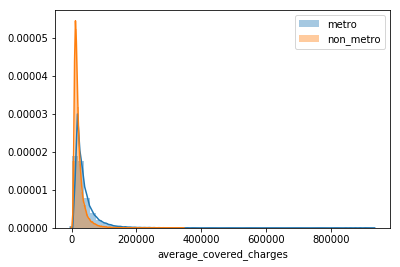

In [206]:
plot_distribution(metro_charges, 'metro', non_metro_charges,'non_metro')

In [220]:
metro_means = get_sample_means(metro_charges,100)


In [221]:
non_metro_means = get_sample_means(non_metro_charges,100)


In [222]:
st.ttest_ind(metro_means, non_metro_means, equal_var=False)

Ttest_indResult(statistic=1297.839002065847, pvalue=0.0)

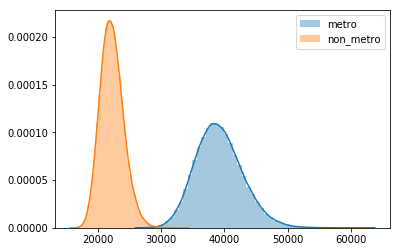

In [223]:
plot_distribution(metro_means, 'metro', non_metro_means,'non_metro')

In [21]:
Cohen_d(metro_means, non_metro_means)

5.794573304594597

### Patient Deductible/Charges

In [194]:
metro_deductible = create_metro_dataset('deductible')

In [195]:
non_metro_deductible = create_non_metro_dataset('deductible')

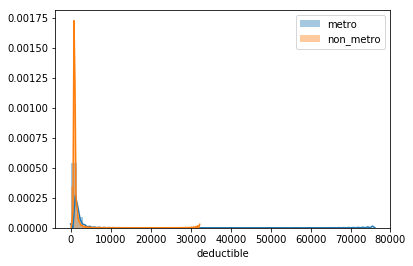

In [209]:
plot_distribution(metro_deductible, 'metro', non_metro_deductible,'non_metro')

In [224]:
metro_deductible_means = get_sample_means(metro_deductible,100)


In [225]:
non_metro_deductible_means =get_sample_means(non_metro_deductible,100)


In [27]:
st.ttest_ind(metro_deductible_means, non_metro_deductible_means, equal_var=False)

Ttest_indResult(statistic=556.8236145487588, pvalue=0.0)

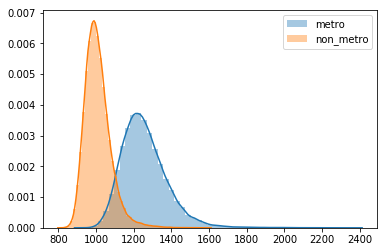

In [210]:
plot_distribution(metro_deductible_means, 'metro', non_metro_deductible_means,'non_metro')

In [29]:
Cohen_d(metro_deductible_means, non_metro_deductible_means)

2.49020335826425

__% Charges Paid for Treatment__

In [196]:
metro_perc_paid = create_metro_dataset('perc_paid')

In [197]:
non_metro_perc_paid = create_non_metro_dataset('perc_paid')

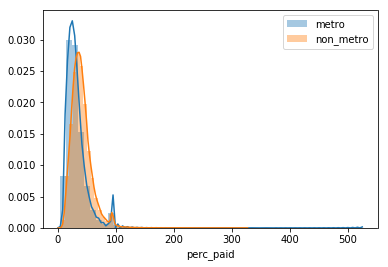

In [211]:
plot_distribution(metro_perc_paid, 'metro', non_metro_perc_paid,'non_metro')

In [226]:
metro_perc_paid_means = get_sample_means(metro_perc_paid,100)

In [227]:
non_metro_perc_paid_means = get_sample_means(non_metro_perc_paid,100)

In [228]:
st.ttest_ind(metro_perc_paid_means, non_metro_perc_paid_means, equal_var=False)

Ttest_indResult(statistic=-1150.914205488702, pvalue=0.0)

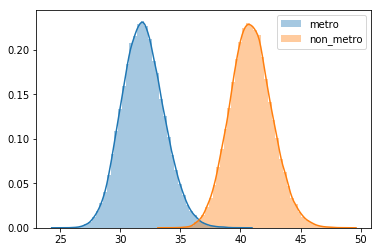

In [229]:
plot_distribution(metro_perc_paid_means, 'metro', non_metro_perc_paid_means,'non_metro')

In [38]:
Cohen_d(metro_perc_paid_means, non_metro_perc_paid_means)

-5.1672498924728325

__Medicare coverage ratio vs Hospital's charge__

In [ ]:
clean_data.head()

In [42]:
metro_med_vs_hosp = create_metro_dataset('med_vs_hosp')

In [43]:
non_metro_med_vs_hosp = create_non_metro_dataset('med_vs_hosp')

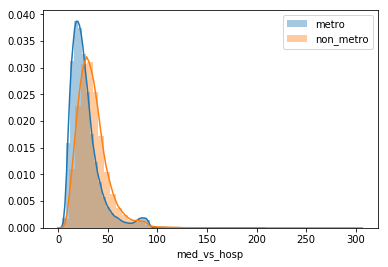

In [205]:
plot_distribution(metro_med_vs_hosp, 'metro', non_metro_med_vs_hosp,'non_metro')


In [ ]:
metro_med_vs_hosp_means = get_sample_means(metro_med_vs_hosp,100)

In [218]:
non_metro_med_vs_hosp_means = get_sample_means(non_metro_med_vs_hosp,100)

In [219]:
st.ttest_ind(metro_med_vs_hosp_means, non_metro_med_vs_hosp_means, equal_var=False)

Ttest_indResult(statistic=-1064.543363723095, pvalue=0.0)

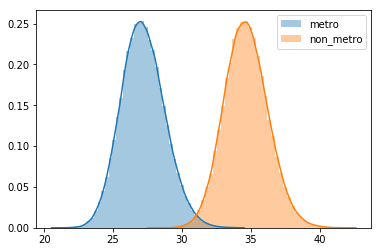

In [214]:
plot_distribution(metro_med_vs_hosp_means, 'metro', non_metro_med_vs_hosp_means,'non_metro')

In [49]:
Cohen_d(metro_med_vs_hosp_means, non_metro_med_vs_hosp_means)

-4.750519050295624

__By DRG__

In [237]:
clean_data.groupby('Group').mean().sort_values('average_medicare_payments', ascending = False)

,key_0,average_covered_charges,average_medicare_payments,average_medicare_payments_2,provider_id,provider_zip_code,total_discharges,deductible,perc_paid,med_vs_hosp,drg_code
Group,,,,,,,,,,,
"MDC 18: INFECTIOUS & PARASITIC DISEASES, SYSTEMIC OR UNSPECIFIED SITES",867.959906,71195.981216,20180.411748,18701.541450,253215.703485,49468.326651,64.676101,1478.870297,35.959030,32.710139,867.959906
MDC 08: DISEASES & DISORDERS OF THE MUSCULOSKELETAL SYSTEM & CONN TISSUE,494.835504,48304.841634,13153.108892,11425.468578,257280.036030,48623.628568,53.476014,1727.640314,32.219270,27.430475,494.835504
MDC 06: DISEASES & DISORDERS OF THE DIGESTIVE SYSTEM,376.067685,38006.237997,10325.498774,9124.825890,253753.921627,47894.273117,38.428881,1200.672885,33.214695,28.289253,376.067685
MDC 04: DISEASES & DISORDERS OF THE RESPIRATORY SYSTEM,191.891019,35063.120774,9530.200898,8399.636471,257583.525386,48083.624213,41.728891,1130.564427,34.731593,29.753610,191.891019
MDC 05: DISEASES & DISORDERS OF THE CIRCULATORY SYSTEM,286.898554,36999.302110,9484.668749,8260.876160,255124.457727,47840.243629,42.386263,1223.792590,32.096786,27.243328,286.898554
MDC 07: DISEASES & DISORDERS OF THE HEPATOBILIARY SYSTEM & PANCREAS,425.513824,36827.837041,9001.224485,7502.867767,253124.391023,47371.055296,18.790664,1498.356718,30.338241,25.243950,425.513824
MDC 11: DISEASES & DISORDERS OF THE KIDNEY & URINARY TRACT,687.786527,27127.622094,7735.041442,6777.775206,257825.359500,48010.105607,47.610407,957.266236,35.625677,30.807221,687.786527
MDC 01: DISEASES & DISORDERS OF THE NERVOUS SYSTEM,67.908193,28102.822730,7237.297644,6086.405372,253197.204734,46992.507491,34.928036,1150.892272,31.771843,26.376693,67.908193
MDC 19: MENTAL DISEASES & DISORDERS,885.000000,19929.451387,6968.721876,5864.125644,249210.380098,46881.869494,146.383361,1104.596232,44.798483,37.939576,885.000000
